In [ ]:
import numpy as np
import random
import tensorflow as tf
from collections import deque
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import make_interp_spline
from scipy.optimize import minimize
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
!pip install Riskfolio-Lib
import riskfolio as rp
import holidays
import datetime
import calendar

In [ ]:
def calc_vol(returns):
  half_life_6_days = 65
  half_life_24_days = 120

  # Initialize DataFrame to hold results
  results_df = pd.DataFrame(columns=['Date', 'Final Estimate'])

  # Iterate through each day
  for i in range(len(returns)):
    if i >= half_life_24_days:
      window_data = returns[i-half_life_24_days+1:i+1]  # Get data for the rolling window
  # Calculate estimates based on different half-lives
      estimate_6_days = window_data.ewm(span=half_life_6_days, min_periods=half_life_6_days).std()
      estimate_24_days = window_data.ewm(span=half_life_24_days, min_periods=half_life_24_days).std()

  # Calculate final estimate as described (maximum of 6-day and 24-day estimate * 0.5)
      final_estimate = max(estimate_6_days.iloc[-1], estimate_24_days.iloc[-1] * 0.5)

    # Record date and final estimate
      result_row = {'Date': returns.index[i], 'Vol': final_estimate}
      results_df = results_df.append(result_row, ignore_index=True)
  results_df=results_df.set_index('Date')
  results_df.index=pd.to_datetime(results_df.index,format='%Y-%m-%d')
  return results_df

In [ ]:
fp=pd.read_excel('/content/Final Port.xlsx')
carry_data=pd.read_excel('/content/Carry Data.xlsx')
vix=pd.read_excel('/content/VIX_Ind.xlsx')
vix=vix.iloc[::-1].reset_index(drop=True)

fp.Dates=pd.to_datetime(fp.Dates,format="%Y-%m-%d")
vix.Date=pd.to_datetime(vix.Date,format="%Y-%m-%d")

In [ ]:
forwards=fp[['Dates','BCN3M Curncy','CZK3M Curncy','KWN3M Curncy','NOK3M Curncy','PLN3M Curncy','SEK3M Curncy','HUF3M Curncy','AUD3M Curncy','HKD3M Curncy','EURCZK3M Curncy',
             'BCN1M Curncy','CZK1M Curncy','KWN1M Curncy','NOK1M Curncy','PLN1M Curncy','SEK1M Curncy','HUF1M Curncy','AUD1M Curncy','HKD1M Curncy','EURCZK1M Curncy']]
forwards=forwards.set_index('Dates')
forwards.index=pd.to_datetime(forwards.index,format="%Y-%m-%d")
spot=pd.read_excel('/content/Spot.xlsx')
spot=spot.set_index('Dates')
spot.index=pd.to_datetime(spot.index,format="%Y-%m-%d")
forwards=forwards.rename({'BCN3M Curncy':'BRL3M Curncy','BCN1M Curncy':'BRL1M Curncy','KWN3M Curncy':'KRW3M Curncy','KWN1M Curncy':'KRW1M Curncy'},axis='columns')
forwards1=forwards

In [ ]:
fwd_tickers=['BRL','CZK','KRW','NOK','PLN','SEK','HUF','AUD','HKD','EURCZK']
for i in fwd_tickers:
  forwards[f'{i}3M Curncy']=(forwards[f'{i}3M Curncy']/10000)+spot[f'{i} Curncy']
  forwards[f'{i}1M Curncy']=(forwards[f'{i}1M Curncy']/10000)+spot[f'{i} Curncy']
forwards

,BRL3M Curncy,CZK3M Curncy,KRW3M Curncy,NOK3M Curncy,PLN3M Curncy,SEK3M Curncy,HUF3M Curncy,AUD3M Curncy,HKD3M Curncy,EURCZK3M Curncy,BRL1M Curncy,CZK1M Curncy,KRW1M Curncy,NOK1M Curncy,PLN1M Curncy,SEK1M Curncy,HUF1M Curncy,AUD1M Curncy,HKD1M Curncy,EURCZK1M Curncy
Dates,,,,,,,,,,,,,,,,,,,,
1999-12-31,NaN,35.829750,1139.999720,8.012350,4.255000,8.464300,NaN,0.657360,7.776250,36.052580,NaN,35.833250,1139.999720,8.013850,4.185750,8.499150,NaN,0.656975,7.774500,36.040065
2000-01-03,NaN,35.174750,1127.499650,7.884550,4.238750,8.325200,NaN,0.659125,7.773150,36.060355,NaN,35.178250,1127.499650,7.887400,4.167000,8.358650,NaN,0.658745,7.771800,36.047790
2000-01-04,NaN,35.256000,1122.249650,7.942650,4.241000,8.330600,NaN,0.655690,7.774650,36.346845,NaN,35.259350,1122.249785,7.944050,4.163000,8.363750,NaN,0.655263,7.773200,36.334350
2000-01-05,NaN,35.108250,1134.499900,7.938600,4.243000,8.317000,NaN,0.658609,7.774300,36.255100,NaN,35.112400,1134.499785,7.942200,4.166500,8.350450,NaN,0.658156,7.772700,36.242645
2000-01-06,NaN,35.101850,1146.249900,7.937750,4.188000,8.321400,NaN,0.654012,7.776500,36.253645,NaN,35.105450,1146.249785,7.941250,4.118500,8.354950,NaN,0.653564,7.774000,36.241110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-17,5.09618,23.320613,1353.549290,10.923188,4.188479,10.862445,363.440000,0.638679,7.812376,24.676030,5.058090,23.319808,1353.549780,10.942410,4.181208,10.896470,363.413279,0.637240,7.818803,24.667300
2023-10-18,5.11502,23.429657,1349.599285,11.016138,4.235501,10.976400,364.553578,0.635825,7.815512,24.696857,5.077018,23.428650,1349.599788,11.035845,4.228250,11.011029,364.525286,0.634342,7.823450,24.687796
2023-10-19,5.12278,23.276150,1357.299275,10.974601,4.216324,10.914234,361.787750,0.635019,7.812604,24.648538,5.089180,23.275260,1357.299778,10.992625,4.209380,10.946491,361.760296,0.633612,7.819228,24.640110


In [ ]:
carry_data=carry_data.set_index('Dates')
carry_data.index=pd.to_datetime(carry_data.index,format='%Y-%m-%d')
fwd1=carry_data.iloc[:,:16]
spt1=carry_data.iloc[:,16:]

fwd1=fwd1.drop(columns=['BRL3M Curncy', 'INR3M Curncy','KWN3M Curncy','PLN3M Curncy','HUF3M Curncy'])
fwd1=fwd1.rename({'EPN3M Curncy':'EGP3M Curncy','APN3M Curncy':'ARS3M Curncy','CHN3M Curncy':'CLP3M Curncy','IHN3M Curncy':'IDR3M Curncy','NTN3M Curncy':'TWD3M Curncy',
                  'UX1 Index':'VIX1 Index','FVS1 Index':'V2X1 Index'},axis='columns')

spt1=spt1.drop(columns=['INR Curncy','BRL Curncy','KRW Curncy','PLN Curncy','HUF Curncy'])

In [ ]:
fp=fp.set_index('Dates')


fp.index=pd.to_datetime(fp.index,format="%Y-%m-%d")
fp=fp.drop(columns=['BCN3M Curncy','CLNI3M Curncy','ZAR3M Curncy','CZK3M Curncy','KWN3M Curncy','NOK3M Curncy','PLN3M Curncy','SEK3M Curncy','HUF3M Curncy','AUD3M Curncy','HKD3M Curncy','EURCZK3M Curncy',
                    'BCN1M Curncy','CZK1M Curncy','CLNI1M Curncy','ZAR1M Curncy','KWN1M Curncy','NOK1M Curncy','PLN1M Curncy','SEK1M Curncy','HUF1M Curncy','AUD1M Curncy','HKD1M Curncy','EURCZK1M Curncy'])
#fp=pd.concat([fp,forwards],axis=1)

fp=fp.loc[(fp.index>=pd.to_datetime("2001-01-01",format='%Y-%m-%d'))&(fp.index<=pd.to_datetime("2023-09-01",format='%Y-%m-%d'))]

#fp=fp.drop(fp.loc[fp.index.isin(df.index)].index)
fp1=fp.pct_change()
fp1=fp1.dropna()


In [ ]:
fp1

,TY1 Comdty,TU1 Comdty,FV1 Comdty,RX1 Comdty,CN1 Comdty,XM1 Comdty,US1 Comdty,DU1 Comdty,OE1 Comdty,UB1 Comdty,...,GX1 Index,SM1 Index,NQ1 Index,NK1 Index,VG1 Index,HI1 Index,ER4 Comdty,ER8 Comdty,IR2 Comdty,BA8 Comdty
Dates,,,,,,,,,,,,,,,,,,,,,
2001-01-02,0.012666,0.004768,0.008449,0.008207,0.008552,-0.000053,0.015830,0.001752,0.004526,0.010128,...,-0.024615,0.000000,-0.087176,0.000000,-0.015378,-0.020844,0.001937,0.001838,0.000317,0.001375
2001-01-03,-0.013390,-0.001761,-0.008827,0.000274,-0.008670,0.001428,-0.017348,-0.000583,-0.001314,0.004047,...,0.023502,-0.008505,0.167013,0.000000,-0.018573,-0.012530,-0.000418,-0.000472,0.001269,-0.000422
2001-01-04,0.007457,0.003067,0.005434,-0.001371,0.001538,-0.001426,0.006583,0.001166,0.000188,-0.007238,...,-0.008322,0.001225,-0.017197,-0.007994,0.036559,0.043116,0.000575,-0.000315,0.000634,0.000211
2001-01-05,0.005329,0.002905,0.004804,0.002472,0.002783,0.000529,0.004459,0.001068,0.001880,0.004245,...,-0.001476,-0.015545,-0.077434,0.011722,-0.015768,0.013080,0.000888,0.000472,0.001055,0.001056
2001-01-08,0.002503,0.001220,0.002092,-0.000274,0.000957,0.000106,0.000000,-0.000097,0.000094,-0.001195,...,0.000000,0.000373,0.013734,0.000000,0.001476,-0.005746,-0.000157,-0.000052,-0.000211,0.000211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-28,0.001856,0.000154,0.000961,-0.001438,0.001690,0.000209,0.001566,-0.000571,-0.000865,-0.004246,...,0.010145,0.008949,0.007560,0.017072,0.014131,0.010972,-0.000260,-0.000052,-0.000104,0.000210
2023-08-29,0.006270,0.002162,0.004654,0.004549,0.005990,0.000417,0.009640,0.000286,0.002425,0.009747,...,0.008907,0.006154,0.021418,0.001243,0.007199,0.013663,0.000260,0.000567,-0.000104,0.001468
2023-08-30,0.000283,0.000270,0.000368,-0.001358,0.001929,0.000313,0.000258,-0.000143,-0.000605,-0.001659,...,-0.002442,-0.000720,0.005546,0.002173,-0.002306,-0.001196,0.000000,-0.000052,0.000313,0.000733


In [ ]:
vol_df1=pd.read_excel('/content/Vol.xlsx')

In [ ]:
vol_df1=vol_df1.set_index('Date')
vol_df1.index=pd.to_datetime(vol_df1.index,format='%Y-%m-%d')

In [ ]:
vol_df1=0.15/(np.sqrt(252)*vol_df1)
vol_df1

,TY1 Comdty_Vol,TU1 Comdty_Vol,FV1 Comdty_Vol,RX1 Comdty_Vol,CN1 Comdty_Vol,XM1 Comdty_Vol,US1 Comdty_Vol,DU1 Comdty_Vol,OE1 Comdty_Vol,UB1 Comdty_Vol,...,GX1 Index_Vol,SM1 Index_Vol,NQ1 Index_Vol,NK1 Index_Vol,VG1 Index_Vol,HI1 Index_Vol,ER4 Comdty_Vol,ER8 Comdty_Vol,IR2 Comdty_Vol,BA8 Comdty_Vol
Date,,,,,,,,,,,,,,,,,,,,,
2001-06-20,2.305598,9.200819,3.415544,3.673749,2.195596,14.095886,1.645643,10.022890,4.856535,2.174927,...,0.725037,0.928966,0.278358,0.561165,0.684159,0.589600,16.334302,20.980584,10.936884,14.327916
2001-06-21,2.341013,9.347338,3.478678,3.654441,2.227227,14.231880,1.670427,10.081982,4.870987,2.191194,...,0.731758,0.939147,0.283130,0.567651,0.695200,0.571467,16.488966,21.315511,11.116405,14.549988
2001-06-22,2.380129,9.505874,3.536863,3.684862,2.223346,14.417936,1.689103,10.243827,4.937634,2.210086,...,0.738378,0.953692,0.286598,0.547232,0.707197,0.552059,16.652227,21.357137,11.282701,14.763424
2001-06-25,2.361824,9.565708,3.490692,3.674099,2.206793,14.576841,1.655673,10.216129,4.854149,2.197187,...,0.749622,0.957577,0.291667,0.555202,0.714056,0.560631,16.798921,21.632920,11.465214,14.647223
2001-06-26,2.396200,9.688627,3.535069,3.677791,2.216787,14.561645,1.677659,10.357692,4.924551,2.217245,...,0.761246,0.971747,0.296160,0.556624,0.722998,0.569336,16.937855,21.905649,11.444393,14.858257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-28,2.156032,7.314093,3.170068,1.798445,1.543548,12.865911,1.239898,8.788801,3.180533,0.823981,...,1.209801,1.409129,0.861204,0.910455,1.009305,0.665152,15.227649,12.529504,17.111978,9.991719
2023-08-29,2.187633,7.621799,3.232313,1.834042,1.572188,13.043529,1.259349,9.054863,3.253198,0.838481,...,1.198789,1.389336,0.868562,0.886880,0.990516,0.667586,15.817594,12.751436,17.379907,10.187388
2023-08-30,2.141173,7.351017,3.143388,1.845222,1.568851,13.166099,1.240949,9.266434,3.282719,0.842940,...,1.194213,1.392409,0.835585,0.902979,0.998020,0.666677,16.099201,12.875428,17.940626,9.915975


In [ ]:
list_fwd=['BRL3M Curncy','CZK3M Curncy','KRW3M Curncy','NOK3M Curncy','PLN3M Curncy','SEK3M Curncy','HUF3M Curncy','AUD3M Curncy','HKD3M Curncy','EURCZK3M Curncy']
for j in list_fwd:
  ticker1=j
  ticker1=ticker1.replace('3M','1M')
  fp[f'{j}_carry']=pd.DataFrame(((fp[j]/fp[ticker1])-1)*(1/61))
  fp1[j]=fp1[j]+fp[f'{j}_carry'].shift(1)
fp1

KeyError: ignored

In [ ]:
for i in fp1.columns:
  fp1[i]=fp1[i]*vol_df1[f'{i}_Vol']
fp1=fp1.dropna()
fp1

,TY1 Comdty,TU1 Comdty,FV1 Comdty,RX1 Comdty,CN1 Comdty,XM1 Comdty,US1 Comdty,DU1 Comdty,OE1 Comdty,UB1 Comdty,...,GX1 Index,SM1 Index,NQ1 Index,NK1 Index,VG1 Index,HI1 Index,ER4 Comdty,ER8 Comdty,IR2 Comdty,BA8 Comdty
Dates,,,,,,,,,,,,,,,,,,,,,
2001-06-20,0.004839,0.004169,0.002558,0.010639,0.003463,0.005994,0.004573,0.007789,0.008717,0.006274,...,-0.007013,-0.005702,0.006237,0.003577,-0.001131,-0.016973,0.005971,0.000000,0.000000,0.000000
2001-06-21,0.001051,-0.001411,0.001562,0.006467,0.009646,-0.005293,0.005143,0.000979,0.003675,0.006303,...,0.005422,-0.000258,0.003837,0.016630,-0.003618,0.016894,0.006025,0.008940,-0.002337,-0.003089
2001-06-22,0.011746,0.010047,0.013231,0.010621,0.011549,0.004598,0.014517,0.010936,0.014424,0.010988,...,-0.001728,-0.009033,-0.000734,0.002105,0.005045,-0.001415,0.006952,0.004477,0.000000,0.010974
2001-06-25,-0.002109,-0.002164,-0.003643,-0.008516,-0.007531,0.009294,-0.003023,0.003962,-0.001368,-0.005853,...,-0.000502,0.001062,0.000666,-0.008934,0.003372,0.000000,0.007010,0.004534,0.009645,-0.003108
2001-06-26,-0.012491,-0.013155,-0.013716,-0.009228,-0.008675,-0.002320,-0.012276,-0.008030,-0.009720,-0.010364,...,-0.007275,-0.014662,0.001433,0.006069,-0.015123,-0.012260,-0.003533,-0.006885,0.000000,-0.007885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-28,0.004002,0.001130,0.003047,-0.002587,0.002609,0.002685,0.001941,-0.005022,-0.002752,-0.003499,...,0.012274,0.012610,0.006511,0.015544,0.014262,0.007298,-0.003953,-0.000646,-0.001788,0.002096
2023-08-29,0.013718,0.016476,0.015043,0.008342,0.009417,0.005442,0.012141,0.002588,0.007889,0.008173,...,0.010677,0.008551,0.018603,0.001103,0.007131,0.009121,0.004107,0.007235,-0.001816,0.014955
2023-08-30,0.000606,0.001982,0.001156,-0.002507,0.003026,0.004118,0.000320,-0.001324,-0.001985,-0.001399,...,-0.002916,-0.001002,0.004634,0.001962,-0.002301,-0.000797,0.000000,-0.000664,0.005624,0.007267


In [ ]:
btop=pd.read_excel('/content/NEIXCTAT.xlsx')

btop=btop.iloc[6:,:]
btop.columns=['Date','Price','Volume']
btop=btop.iloc[::-1].reset_index(drop=True)
btop.Date=pd.to_datetime(btop.Date,format="%Y-%m-%d")

btop=btop.set_index('Date')
btop.index = pd.to_datetime(btop.index,format="%Y-%m-%d")
btop_monthly=btop
btop_monthly['Daily_return']=btop_monthly['Price'].pct_change()
btop_monthly=btop_monthly.dropna()
btop_monthly

,Price,Volume,Daily_return
Date,,,
2000-01-03,997.2,997.2,-0.002800
2000-01-04,970.674,970.674,-0.026600
2000-01-05,962.133,962.133,-0.008799
2000-01-06,953.473,953.473,-0.009001
2000-01-07,944.034,944.034,-0.009900
...,...,...,...
2023-09-08,3860.777,3860.777,0.003296
2023-09-11,3862.454,3862.454,0.000434
2023-09-12,3873.043,3873.043,0.002742


In [ ]:
average_returns_dict={}
for i in fp1.columns:
  average_returns_dict[i] = pd.DataFrame(index=range(2000, 2022))
  ret=pd.DataFrame(fp1[i])
  # Step 4: Calculate the average returns for each month over each year
  for year in range(2010,2023):
    for month in range(1, 13):
      month_name = f'Jan' if month == 1 else calendar.month_abbr[month]
      b=ret.loc[(ret.index.year.isin(pd.Series(np.arange(year-11,year-1))))&(ret.index.month==month), i]

      b=b.loc[np.sign(b-(0.02/252))==-1].std()

      average_returns_dict[i].loc[year,f'{i}_{month_name}_Avg_Return'] = (ret.loc[(ret.index.year.isin(pd.Series(np.arange(year-11,year-1))))&
       (ret.index.month==month), i].mean()-(0.02/252))/b

In [ ]:
b

0.008990731037768077

In [ ]:
month_dict={}
for i in range(0,12):
  month_dict[i]=pd.DataFrame()
  for j in fp1.columns:
    month_dict[i]=pd.concat([month_dict[i],pd.DataFrame(average_returns_dict[j].iloc[:,i])],axis=1)

In [ ]:
month_dict[0]

,TY1 Comdty_Jan_Avg_Return,TU1 Comdty_Jan_Avg_Return,FV1 Comdty_Jan_Avg_Return,RX1 Comdty_Jan_Avg_Return,CN1 Comdty_Jan_Avg_Return,XM1 Comdty_Jan_Avg_Return,US1 Comdty_Jan_Avg_Return,DU1 Comdty_Jan_Avg_Return,OE1 Comdty_Jan_Avg_Return,UB1 Comdty_Jan_Avg_Return,...,GX1 Index_Jan_Avg_Return,SM1 Index_Jan_Avg_Return,NQ1 Index_Jan_Avg_Return,NK1 Index_Jan_Avg_Return,VG1 Index_Jan_Avg_Return,HI1 Index_Jan_Avg_Return,ER4 Comdty_Jan_Avg_Return,ER8 Comdty_Jan_Avg_Return,IR2 Comdty_Jan_Avg_Return,BA8 Comdty_Jan_Avg_Return
2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import cvxpy as cp
def port_opt(ret_p,cov):
  z = cp.Variable(len(ret_p.columns),) #transformed variable
  k = cp.Variable() #scalar (variable)
  ret = z.T@((ret_p.mean()*252).values)
  sigma_square = cp.quad_form(z, ((cov*252).values))
  objective = cp.Minimize(sigma_square)
  constraints = [
      ret == 1, #adjustable return target constraint
      cp.sum(z) == k,
      z >= 0.08,
      k >= 0,
      ]
  prob = cp.Problem(objective, constraints)

  prob.solve(verbose = False)
  w = (z.value / k.value)
  return w

In [ ]:
z=pd.DataFrame()
for i in range(2010,2023):
  for k in range(12):
    #j=str(month_dict[k].loc[month_dict[k].index==i].max(3,axis=1)[i]).split('_',1)[0]
    j=month_dict[k].loc[month_dict[k].index==i].apply(lambda row: row.nlargest(10).index.tolist(), axis=1)[i]
    j=pd.Series(j).apply(lambda x:x.split('_',1)[0]).tolist()
    x=fp1.loc[(fp1.index.month==k+1)&(fp1.index.year==i),j]
    y=fp1.loc[(fp1.index.month==k+1)&(fp1.index.year<i),j]
    y_cov=y.cov()
    w=port_opt(y,y_cov)
    x=x.mul(w, axis=1).sum(axis=1)

    print(j)
    print(w.max())
    z=pd.concat([z,x])
    #z=pd.concat([z,fp1.loc[(fp1.index.month==k+1)&(fp1.index.year==i),j]])

['PL1 Comdty', 'HG1 Comdty', 'QC1 Comdty', 'LA1 Comdty', 'PA1 Comdty', 'SB1 Comdty', 'CC1 Comdty', 'LX1 Comdty', 'KC1 Comdty', 'AD1 Curncy']
0.27194947729255864
['BO1 Comdty', 'QS1 Comdty', 'PL1 Comdty', 'CO1 Comdty', 'BA8 Comdty', 'DU1 Comdty', 'O 1 Comdty', 'TU1 Comdty', 'ER4 Comdty', 'ER8 Comdty']
0.2685525092413046
['NG1 Comdty', 'HG1 Comdty', 'QS1 Comdty', 'JY1 Curncy', 'CO1 Comdty', 'CL1 Comdty', 'HO1 Comdty', 'SI1 Comdty', 'EC1 Curncy', 'SF1 Curncy']
0.3131864408661117
['LH1 Comdty', 'BP1 Curncy', 'AD1 Curncy', 'CD1 Curncy', 'EC1 Curncy', 'BO1 Comdty', 'SM1 Index', 'HG1 Comdty', 'NV1 Curncy', 'HI1 Index']
0.2666820670622069
['FC1 Comdty', 'CD1 Curncy', 'W 1 Comdty', 'C 1 Comdty', 'PT1 Index', 'NV1 Curncy', 'BO1 Comdty', 'SI1 Comdty', 'NQ1 Index', 'PL1 Comdty']
0.2783286693273853
['QC1 Comdty', 'O 1 Comdty', 'CC1 Comdty', 'QS1 Comdty', 'CT1 Comdty', 'HO1 Comdty', 'CO1 Comdty', 'CL1 Comdty', 'SB1 Comdty', 'BP1 Curncy']
0.29529567143257013
['W 1 Comdty', 'RX1 Comdty', 'UB1 Comdty',

In [ ]:
z

,0
2010-01-01,0.000000
2010-01-04,0.009648
2010-01-05,0.006267
2010-01-06,0.006612
2010-01-07,-0.001653
...,...
2022-12-26,0.000000
2022-12-27,0.003736
2022-12-28,0.001872
2022-12-29,0.002846


In [ ]:
fp1.loc[(fp1.index.month==k+1)&(fp1.index.year==i),j]

,LC1 Comdty,C 1 Comdty,LH1 Comdty,SF1 Curncy,CT1 Comdty,OE1 Comdty,EC1 Curncy,RX1 Comdty,NV1 Curncy,BO1 Comdty
Dates,,,,,,,,,,
2022-12-01,-0.000294,-0.013151,0.001089,0.010035,-0.000412,0.016462,0.011723,0.014155,0.010736,-0.044551
2022-12-02,0.003578,-0.016543,-0.003430,-0.001138,-0.005764,-0.006790,0.001798,-0.004788,0.004604,-0.004492
2022-12-05,-0.001510,-0.006868,-0.001754,-0.006607,0.002374,-0.001333,-0.004902,-0.001080,-0.013516,-0.015299
2022-12-06,-0.020527,-0.003642,0.001022,0.000612,-0.001267,0.008514,-0.003578,0.007954,0.000496,-0.005972
2022-12-07,0.004353,0.002576,0.000518,0.002993,-0.010186,-0.019913,0.005853,-0.003836,0.005963,-0.004289
2022-12-08,0.005882,0.004911,-0.001968,0.003945,-0.003733,-0.002965,0.005186,-0.002135,0.002745,0.002139
2022-12-09,0.014835,0.003189,-0.002276,0.003583,0.000391,-0.012850,-0.001724,-0.013909,0.006508,-0.008017
2022-12-12,0.008398,0.007596,0.002050,-0.004968,-0.006352,-0.002255,-0.002897,-0.000375,-0.006169,0.013898
2022-12-13,0.005810,0.014205,0.014487,0.011424,0.009395,0.004779,0.013837,0.003433,0.013440,-0.001615


In [ ]:
str(month_dict[k].loc[month_dict[k].index==i].idxmax(axis=1)[i]).split('_',1)[0]

'LC1 Comdty'

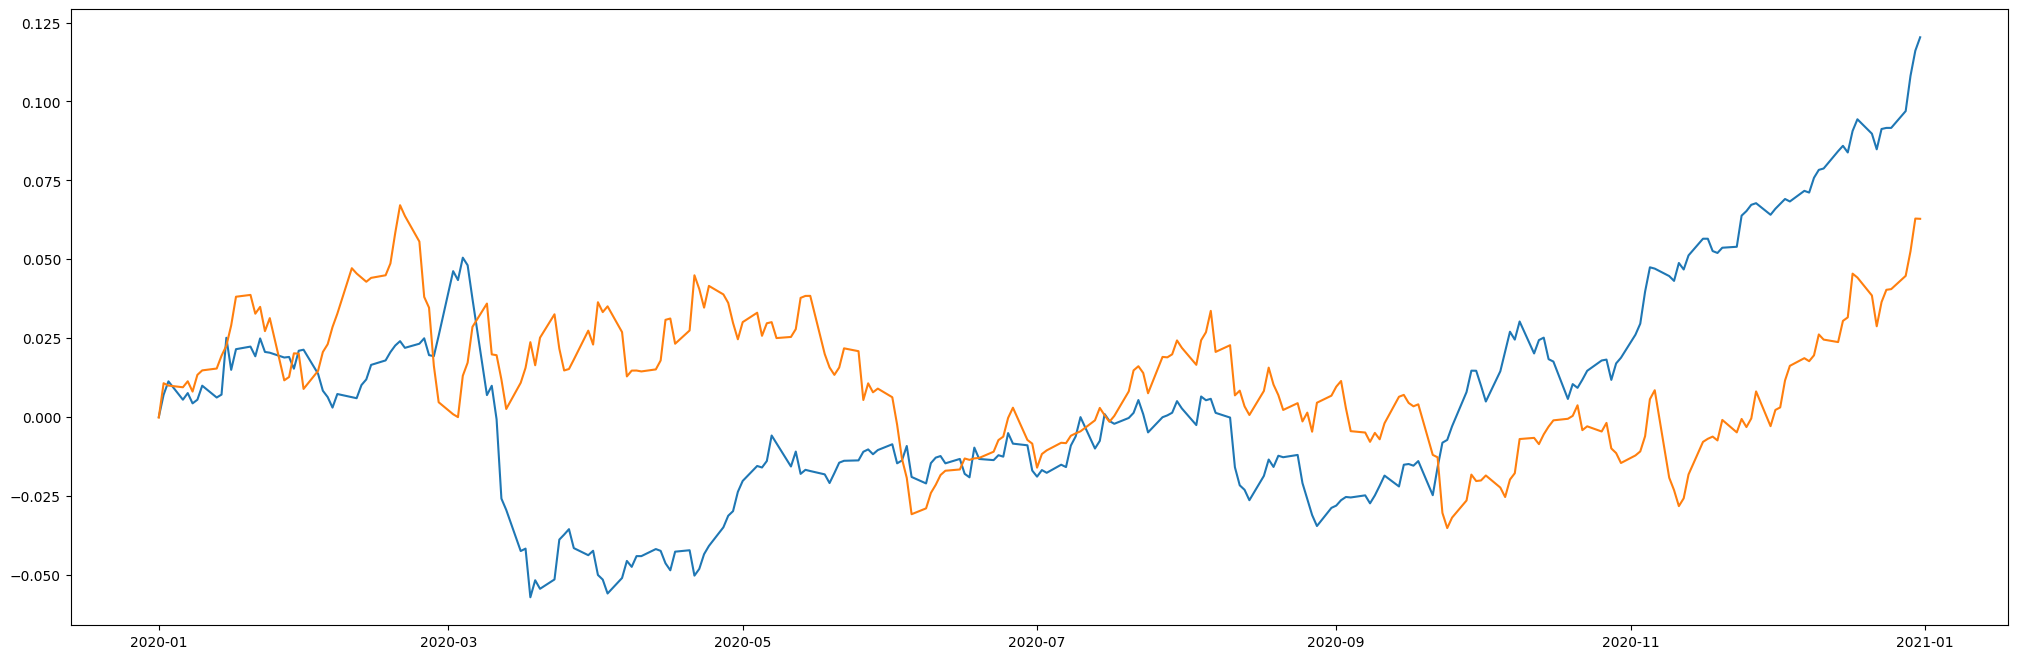

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(np.cumprod(1+z.sort_index().loc[(z.index.year>=2020)&(z.index.year<=2020)])-1)

In [ ]:
z.sort_index().loc[(z.index.year>=2020)&(z.index.year<=2021)].std()*np.sqrt(252)

0    0.094009
dtype: float64

In [ ]:
((np.cumprod(1+z.sort_index()).iloc[-1])**(252/len(z))-1)/(z.std()*np.sqrt(252))

0    1.294415
dtype: float64

In [ ]:
z=pd.concat([z,btop_monthly.loc[btop_monthly.index.year>=2010,'Daily_return']],axis=1)
z.corr()

,0,Daily_return
0,1.000000,0.139198
Daily_return,0.139198,1.000000


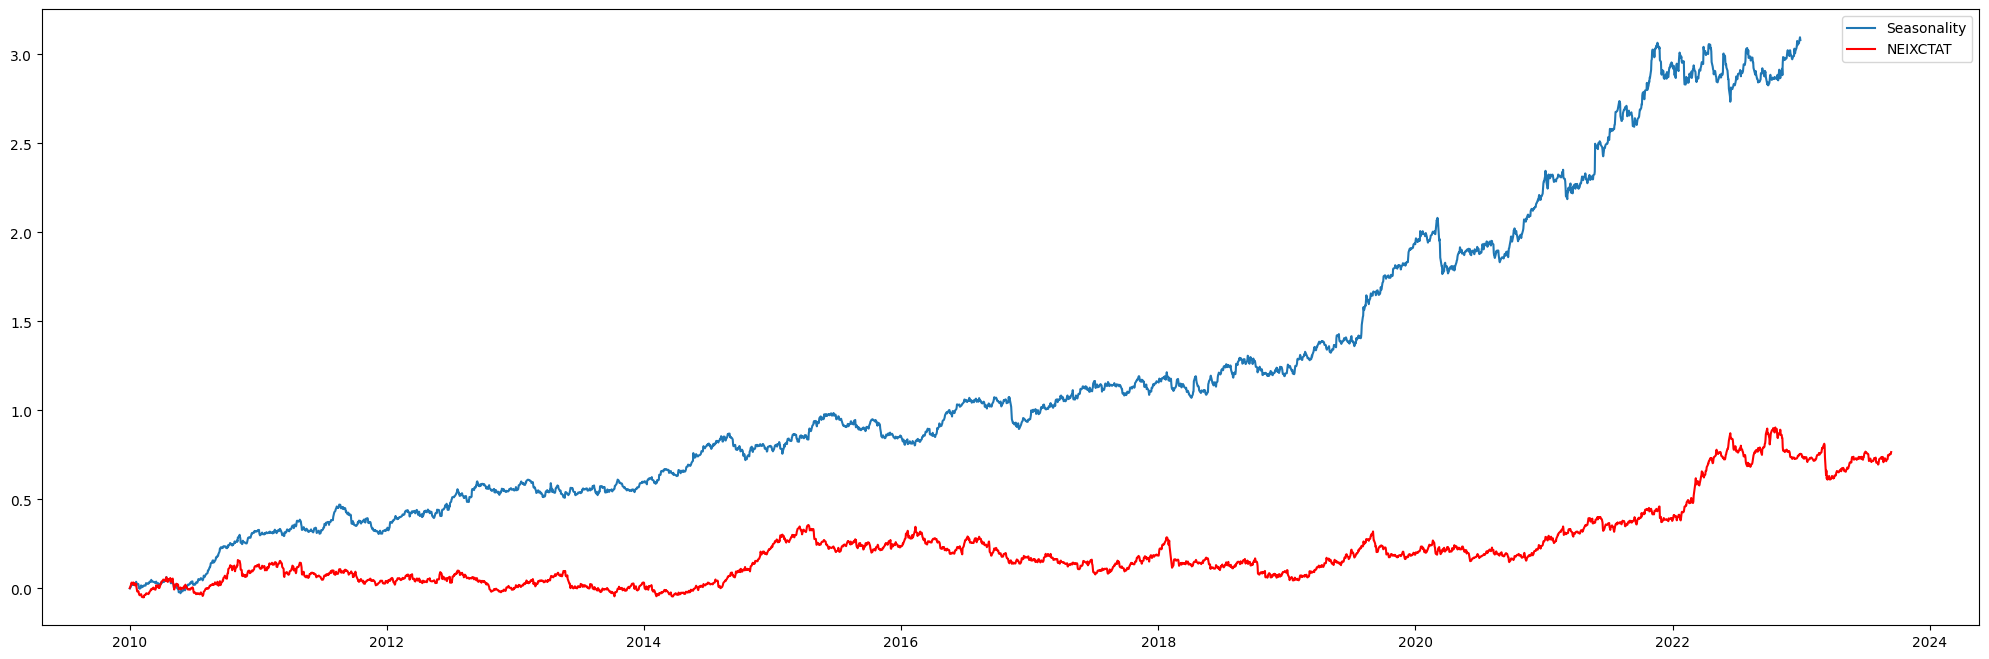

In [ ]:
plt.figure(figsize=(25,8))
plt.plot(np.cumprod(1+z.iloc[:,0])-1,label='Seasonality')
plt.plot(np.cumprod(1+z.iloc[:,1])-1,color='red',label='NEIXCTAT')
plt.legend()

In [ ]:
z.Daily_return.std()*np.sqrt(252)

0.11056646844992536

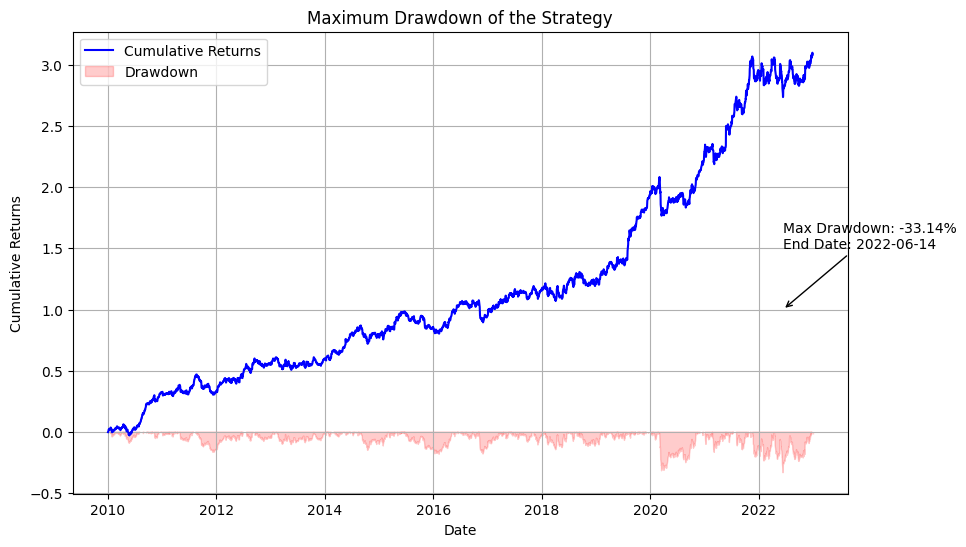

In [ ]:
draw=pd.DataFrame(z.iloc[:,0])
draw.columns=['Seasonality']
draw['Cumulative']=(1 + draw['Seasonality']).cumprod()-1
draw=draw.reset_index()
draw.columns=['Date','Seasonality','Cumulative']
draw['Rolling Max'] = draw['Cumulative'].cummax()
draw['Drawdown'] = draw['Cumulative'] - draw['Rolling Max']

# Calculate the maximum drawdown and its end date
max_drawdown = draw['Drawdown'].min()
max_drawdown_end_date = draw.loc[draw['Drawdown'].idxmin(), 'Date']

# Plot the cumulative returns and highlight the maximum drawdown period
plt.figure(figsize=(10, 6))
plt.plot(draw['Date'],draw['Cumulative'], label='Cumulative Returns', color='blue')
plt.fill_between(draw['Date'],0, draw['Drawdown'], where=draw['Drawdown'] < 0, color='red', alpha=0.2, label='Drawdown')
plt.title('Maximum Drawdown of the Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)

# Annotate the maximum drawdown on the plot
plt.annotate(f'Max Drawdown: {max_drawdown:.2%}\nEnd Date: {max_drawdown_end_date.date()}',
             xy=(max_drawdown_end_date, 1), xytext=(max_drawdown_end_date, 1.5),
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Show the plot
plt.show()

In [ ]:
from scipy.optimize import differential_evolution
from scipy.optimize import LinearConstraint, minimize